In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

import librosa
import seaborn as sns
import IPython.display as ipd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Step 1: Split the dataset into training and testing sets

In [43]:
import os
import random
from sklearn.model_selection import train_test_split


TESS_DIR = './data_folder'

emotions = ['angry', 'fear', 'happy', 'sad']

audio_paths = []
labels = []

for emotion in emotions:
    
    emotion_dir = os.path.join(TESS_DIR, emotion)
    files = os.listdir(emotion_dir)

    for file in files:
        if file.endswith('.wav'):
            audio_paths.append(os.path.join(emotion_dir, file))
            labels.append(emotion)

train_audio_paths, test_audio_paths, train_labels, test_labels = train_test_split(audio_paths, 
                                                                                  labels, 
                                                                                  test_size=0.3, 
                                                                                  random_state=42, 
                                                                                  stratify=labels)


## Step 2: Exploratory Data Analysis

In [44]:
def audio(filename):
    return ipd.Audio(filename)

In [45]:
def waveplot(filename, label, mode='time'):

    waveform, sr = librosa.load(filename)

    if mode == 'time':

        plt.figure(1)
        librosa.display.waveshow(y=waveform, sr=sr)

        plt.title(label)
        plt.xlabel('Time / second')
        plt.ylabel('Amplitude')

        plt.savefig(f"./img/{mode}.png")
        plt.show()

    elif mode == 'freq':
      
        k = np.arange(len(waveform))
        T = len(waveform)/sr
        freq = k/T

        DATA_0 = np.fft.fft(waveform)
        abs_DATA_0 = abs(DATA_0)
        
        plt.figure(2)
        plt.plot(freq, abs_DATA_0)
        
        plt.title(label)
        plt.xlabel("Frequency / Hz")
        plt.ylabel("Amplitude / dB")
        plt.xlim([0, 1000])

        plt.savefig(f"./img/{mode}.png")
        plt.show()
    else:
        print("Incorrect mode. Try again.")

In [46]:
def spectrogram(filename, label):

    waveform, sr = librosa.load(filename)

    D = librosa.stft(waveform)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(3)
    plt.title(label)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')
    plt.colorbar()

    plt.savefig(f"./img/spectrogram.png")
    plt.show()


In [47]:
def distribution():
    
    sns.countplot(x=train_labels)

    plt.savefig(f"./img/dist.png")
    plt.show()

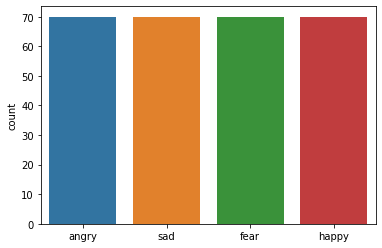

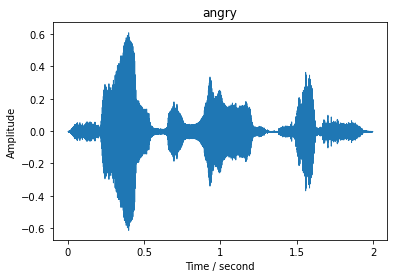

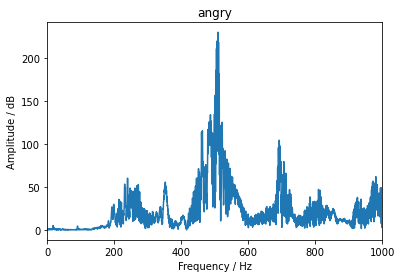

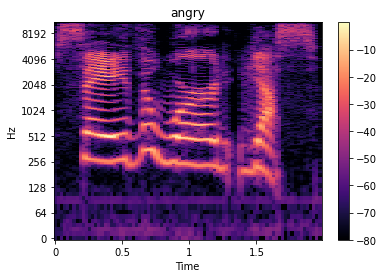

In [48]:
# Load an example audio file
index = np.random.randint(0, len(train_audio_paths))

audio_file = train_audio_paths[index]
label = train_labels[index]

distribution()
waveplot(audio_file, label, mode='time')
waveplot(audio_file, label, mode='freq')
spectrogram(audio_file, label)
audio(audio_file)



## Step 3: Acoustic Feature Extraction

In [49]:
""" Scaling function. """

def scale(arr):

    min_max_scaler = MinMaxScaler(feature_range=(-1,1))
    return min_max_scaler.fit_transform(arr.reshape(-1,1)).reshape(-1)


""" Extract, scale, and average each feature. """

def extract_features(filename):

    feature_vector = []
    signal, sample_rate = librosa.load(filename)

    S, phase = librosa.magphase(librosa.stft(signal))
    rms = librosa.feature.rms(S=S)
    feature_vector.append(np.mean(scale(rms[0])))

    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=60)
    for n_mfcc in range(len(mfccs)):
        feature_vector.append(np.mean(scale(mfccs.T[n_mfcc])))

    zcr = librosa.feature.zero_crossing_rate(y=signal)
    feature_vector.append(np.mean(scale(zcr[0])))
 
    chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    for n_chroma in range(len(chromagram)):
        feature_vector.append(np.mean(scale(chromagram.T[n_chroma])))

    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=60)
    for n_mel in range(len(mel_spectrogram)):
        feature_vector.append(np.mean(scale(mel_spectrogram.T[n_mel])))

    return np.array(feature_vector)



## Step 4: Feature Post-processing

In [50]:
categories = {'angry': 0, 
              'fear': 1,
              'happy': 2, 
              'sad': 3}

X_train, Y_train = [], []

for filename, label in zip(train_audio_paths, train_labels):

    X_train.append(extract_features(filename))
    Y_train.append(categories[label])

X_test, Y_test = [], []

for filename, label in zip(test_audio_paths, test_labels):

    X_test.append(extract_features(filename))
    Y_test.append(categories[label])

## Step 5: Build audio emotion recognition model

In [51]:
""" Import Classifiers and Metrics from Sklearn """

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report, accuracy_score

In [52]:
""" Prepare Labels for Model Training """

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


type(X_train), type(Y_train), type(X_test), type(Y_test)

(list, numpy.ndarray, list, numpy.ndarray)

In [53]:
""" Prepare Data for Model Training """

X_train = np.array(X_train)
X_test = np.array(X_test)

In [54]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((280, 134), (280,), (120, 134), (120,))

In [55]:
""" Initialize Logistic Regression, SVM, Naive Bayes, and Random Forest Classification Algorithms """


svc = SVC(kernel='linear', probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()
# mlp = model = MLPClassifier(alpha = 0.01,
#                             batch_size = 256,
#                             epsilon = 1e-08,
#                             hidden_layer_sizes = (300,),
#                             learning_rate = 'adaptive',
#                             max_iter = 500)

""" Train the Models with Training Dataset """
svc.fit(X_train, Y_train)
nbc.fit(X_train, Y_train)
rfc.fit(X_train, Y_train)
# mlp.fit(X_train, Y_train)

RandomForestClassifier()

In [56]:
""" Test the Models with Testing Dataset """

y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

# y_mlp_predicted = mlp.predict(X_test)
# y_mlp_predicted = mlp.predict_proba(X_test)

## Step 6: Model evaluation

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.91      0.97      0.94        30
           2       0.96      0.83      0.89        30
           3       0.97      1.00      0.98        30

    accuracy                           0.94       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.94      0.94      0.94       120

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.91      1.00      0.95        30
           2       1.00      0.97      0.98        30
           3       1.00      1.00      1.00        30

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.98       120
weighted avg       0.98      0.97      0.98       120

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.

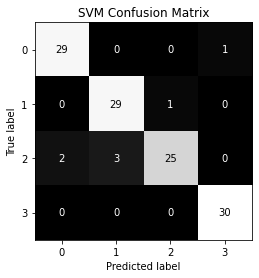

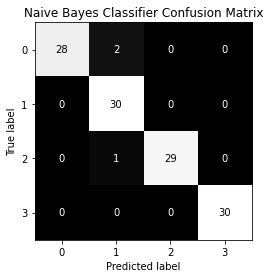

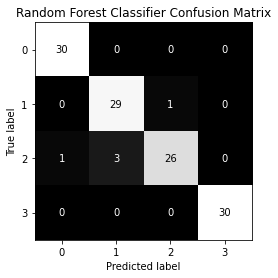

In [57]:
""" Model Evaluation with Confusion Matrix and ROC Curve """

# print(classification_report(y_test, y_lc_predicted))
print(classification_report(Y_test, y_svc_predicted))
print(classification_report(Y_test, y_nbc_predicted))
print(classification_report(Y_test, y_rfc_predicted))

models = ['SVM', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_svc_predicted, y_nbc_predicted,  y_rfc_predicted]
pred_probabilities = [y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

    plt.savefig(f"./img/{model}.png")
    
plt.show()